In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
t0 = time.time()
from matplotlib import pyplot as plt
import os
import re
import scipy.signal

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load the input data
Load the raw channel voltage here. Save it in `voltage_trace` as a 1d numpy array. Save sampling frequency in the variable `Fs`

In [ ]:
voltage_trace = # put your loaded raw (unfiltered) channel data here
Fs = # loaded data sampling frequency goes here

In [ ]:
# Plotting a snapshot of the voltage trace (sub-sampled to 1/10th)
plt.figure(figsize=(15,5))
plt.plot(np.arange(0,voltage_trace.size/Fs,10/Fs),voltage_trace[::10])
plt.xlabel('Time')
plt.ylabel('Voltage')

In [18]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(voltage_trace, dt)
css.num_gmm_components = 3 # if data is noisy, increase this to higher odd numbers
css.cs_num_gmm_components = 4

# this is the windows that the algorithm looks around each spike for classification. If data has a very high frequecny (>60Hz) spiking activity, decrease this window
css.pre_window = 0.0002
css.post_window = 0.0030
# Run the algorithm
css.run(use_filtered=False, remove_overlap=False, spike_detection_dir = 'min', align_spikes_to='min')
print('Signal length = {}'.format(css.voltage.size*css.dt))
print('number of detected CS = {}'.format(css.cs_indices.size))

Pre-process...
Using minibatch spike detection, batch size = 50s, using filter (derivative) is False
Using spikes min for detection. Aligning them to their min. 
Spike detection time = 35.24626016616821
Using all spikes for alignment (no overlap removal)
Align spikes time = 0.238084077835083
Clustering complex spikes...
Splitting detected spikes for CS clustering ...
CS spike detection time = 24.046628713607788
Merging overlapping CS waveforms
CS post process time = 0.0030972957611083984
Signal length = 1468.3136000000002
number of detected CS = 1363


## De-noising step:
* Here we further classify the detected complex spikes in their time domain and remove potential false positives.
* `slice_length` determines the signal slice length (in seconds) for each step of de-noising. If there is amplitude drift in your signal (increasing, or decreasing voltage amplitude) then decrease this number.
* `num_clusters` determines number of clusters for time domain clustering (de-noising). No set formula for this. I usually use 6, or 8 clusters.

In [28]:
from sklearn.mixture import GaussianMixture
num_clusters = 8
slice_length = 300
pre_time = 0.0005
post_time = 0.0030
align_to='min'

delta = int(slice_length/css.dt)
if css.signal_size > (slice_length + slice_length/2.0)/css.dt:
    print('Splitting detected spikes for CS clustering ...')
    cs_slice_indices = []
    countall = 0
    for i in np.arange(0, css.signal_size, delta):
        cs_slice_indices.append(np.where(np.logical_and(css.cs_indices >= i ,  css.cs_indices < i + delta))[0])
    # If the last chunk is less than 2 minutes, merge it with the penultimate chunk:
    if cs_slice_indices[-1].size <= (slice_length/2.0)/css.dt:
        cs_slice_indices[-2] = np.concatenate((cs_slice_indices[-2], cs_slice_indices[-1]))
        del cs_slice_indices[-1]
else:
    cs_slice_indices = [np.arange(0, css.cs_indices.size)]



pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
clusters_for_slice = []
cluster_labels_for_slice = []
gmm = GaussianMixture(num_clusters, covariance_type = 'full', warm_start=False)
for ccslice in cs_slice_indices:
    if align_to is 'min':
        aligned_cs = np.array([css.voltage[i - pre_index : i + post_index] for i in css.cs_indices[ccslice]])
    elif align_to is 'max':
        aligned_cs = []
        for csi in css.cs_indices[ccslice]:
            align_point = np.argmax(css.voltage[csi - pre_index : csi + post_index]) + csi-pre_index
            aligned_cs.append(css.voltage[align_point - pre_index : align_point + post_index])
        aligned_cs = np.array(aligned_cs)
    else:
        raise ValueError("align_to should be min or max")
    gmm.fit(aligned_cs)
    cluster_labels = gmm.predict(aligned_cs)
    clusters = []
    for cn in np.arange(num_clusters):
        clusters.append(aligned_cs[np.where(cluster_labels == cn)])
    clusters_for_slice = clusters_for_slice + [clusters]
    cluster_labels_for_slice = cluster_labels_for_slice + [cluster_labels]



def plot_clusters(ax, i):
    clusters = clusters_for_slice[i]
    colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
    legend_labels = []
    for cn in np.arange(num_clusters):
        legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

    import gc
    gc.collect()
    
#     fig.figsize = (18,5)
    clust_means = []
    paxes = []
    for cn in np.arange(num_clusters):
        clust_means.append(np.mean(clusters[cn], axis=0))
        ax.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
        paxes.append(ax)
    ax.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
    ax.legend() 
    ax.set_title('Batch #{}'.format(i))
    fig.canvas.draw()
    
    

Splitting detected spikes for CS clustering ...


In [30]:
import random
ss_indices = css.get_ss_indices()
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

* In here, choose the clusters that are complex spikes nad write them in the text box (comma separated) and press enter. For comparison, avn average voltage waveform of the detected simple spikes are provided in dash lines.

<IPython.core.display.Javascript object>


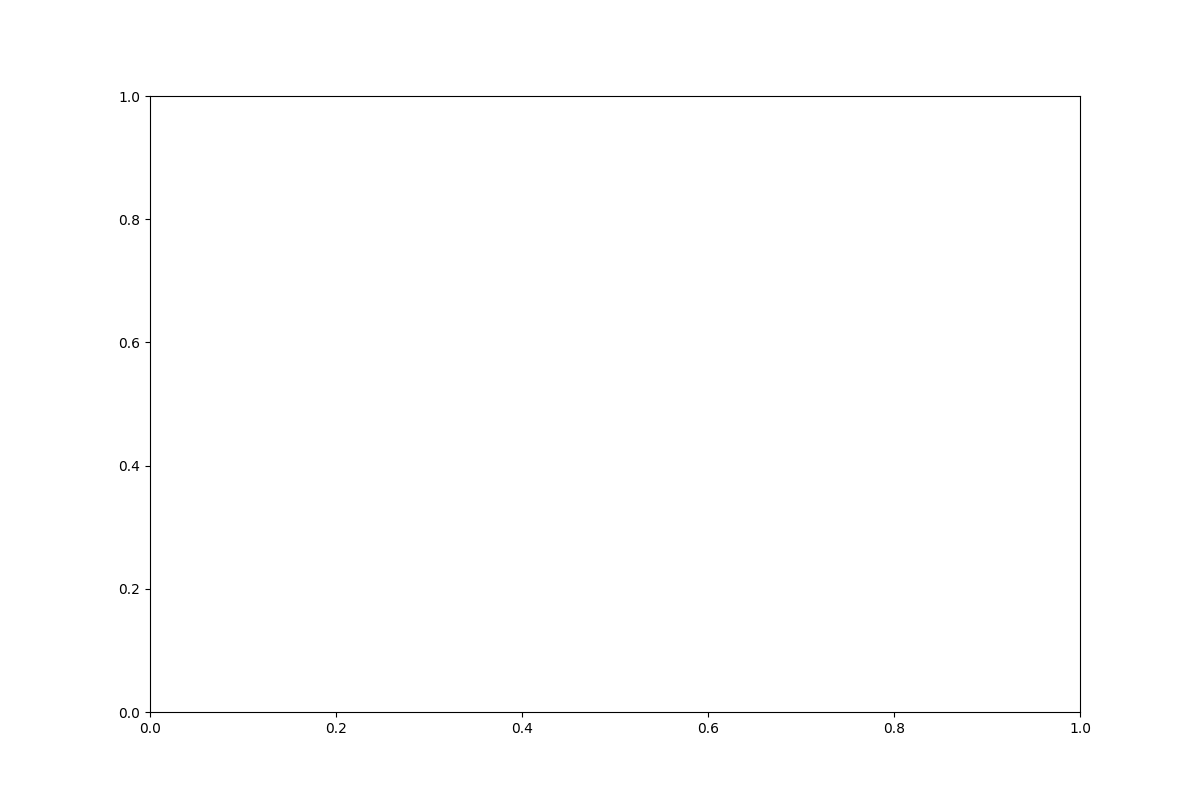

Text(value='')

In [31]:
import ipywidgets as widgets
fig,ax = plt.subplots(1,1,figsize=(12,8))
answers = []
plot_counter = [1]
plot_clusters(ax,0)
text = widgets.Text()
def handle_submit(sender):
    update_plot(answers)
    
def update_plot(answers):
    if plot_counter[0] < len(clusters_for_slice):
        ans_regex = re.compile(r'\d+(?:,\d+)?')
        if ans_regex.match(text.value):
            answers.append(text.value)
            ax.cla()
            plot_clusters(ax,plot_counter[0])
            plot_counter[0] = plot_counter[0] + 1
            text.value = ''

    else:
        answers.append(text.value)
        ax.cla()
        text.value = 'THAT\'S ALL'
#     return answers
text.on_submit(handle_submit)
display(text)



In [32]:
picked_clusters = [[int(c) for c in ans.split(',')] for ans in answers]
cs_indices_to_pick = []
for i, clusters_to_pick in enumerate(picked_clusters):
    for cti in clusters_to_pick:
        cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[cs_slice_indices[i]][np.where(cluster_labels_for_slice[i] == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))    
    

Number of detected CS: (1260,)


## Sanity check:
We find the cross correlation of CSxSS (Complex Spikes cross-correlated with Simple Spikes). The Complex spikes induce a longer than normal refractory period in simple spike activity. If that refractory period is not apparent in the cross correlation plot, either the detected CS are missclassified or, the recorded CS and SS are from different cells.

<IPython.core.display.Javascript object>


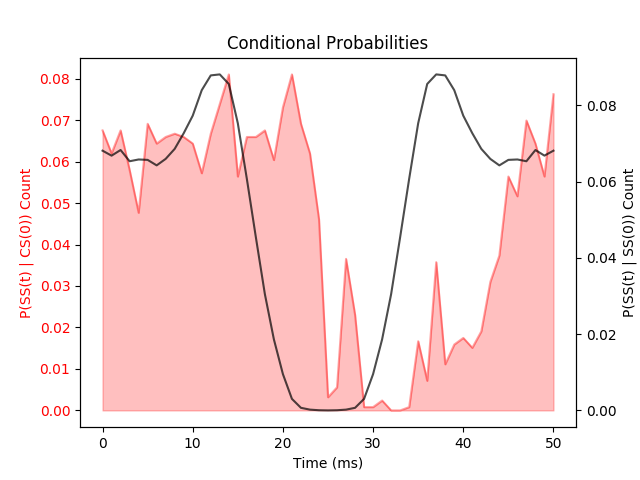

Text(0.5, 1.0, 'Conditional Probabilities')

In [33]:
window = 25

SS = np.zeros(np.int64(css.signal_size/(Fs/1000.0)))
SS[np.int64(ss_indices/(Fs/1000.0))] = 1
CS = np.zeros(np.int64(css.signal_size/(Fs/1000.0)))
CS[np.int64(cs_indices/(Fs/1000.0))] = 1



xcor_vect = np.zeros((2*window + 1))
first_cs_acor = np.argmax(cs_indices > window*(Fs/1000.0))
last_cs_acor = np.argmax(cs_indices[::-1] < ss_indices[-1] - window*30) + 1
for cti in np.int64(cs_indices[first_cs_acor:-1]/(Fs/1000.0)):
    xcor_vect = xcor_vect + SS[cti-window : cti + window + 1]

xcor_vect = xcor_vect / (cs_indices.size - (first_cs_acor + last_cs_acor))
    
acor_vect = np.zeros((2*window + 1))
first_ss_acor = np.argmax(ss_indices > window*(Fs/1000.0))
last_ss_acor = np.argmax(ss_indices[::-1] < ss_indices[-1] - window*(Fs/1000.0)) + 1
for sti in np.int64(ss_indices[first_ss_acor:-last_ss_acor]/(Fs/1000.0)):
    acor_vect = acor_vect + SS[sti-window : sti + window + 1]

acor_vect[window] = 0

acor_vect = acor_vect / (ss_indices.size - (first_ss_acor + last_ss_acor))

plt.figure()
plt.plot(xcor_vect, 'r', alpha=0.35)
plt.yticks(color='r')
plt.fill_between(np.arange(0,2*window + 1), xcor_vect, color='r', alpha=0.25)
plt.ylabel('P(SS(t) | CS(0)) Count', color = 'r')
plt.xlabel('Time (ms)')

plt.twinx()
plt.plot(acor_vect, 'k', alpha=0.70)
plt.yticks(color='k')
plt.ylabel('P(SS(t) | SS(0)) Count', color = 'k')
# plt.fill_between(acor_ret[0], 0, acor_ret[1] , color='g', alpha=0.25)
plt.title('Conditional Probabilities')

In [34]:
plt.savefig(os.path.join(source_path, 'CH_{}.png'.format(chan_index)))
plt.savefig(os.path.join(source_path, 'CH_{}.svg'.format(chan_index)))
         

## Visualizing the detected Complex Spikes

<IPython.core.display.Javascript object>


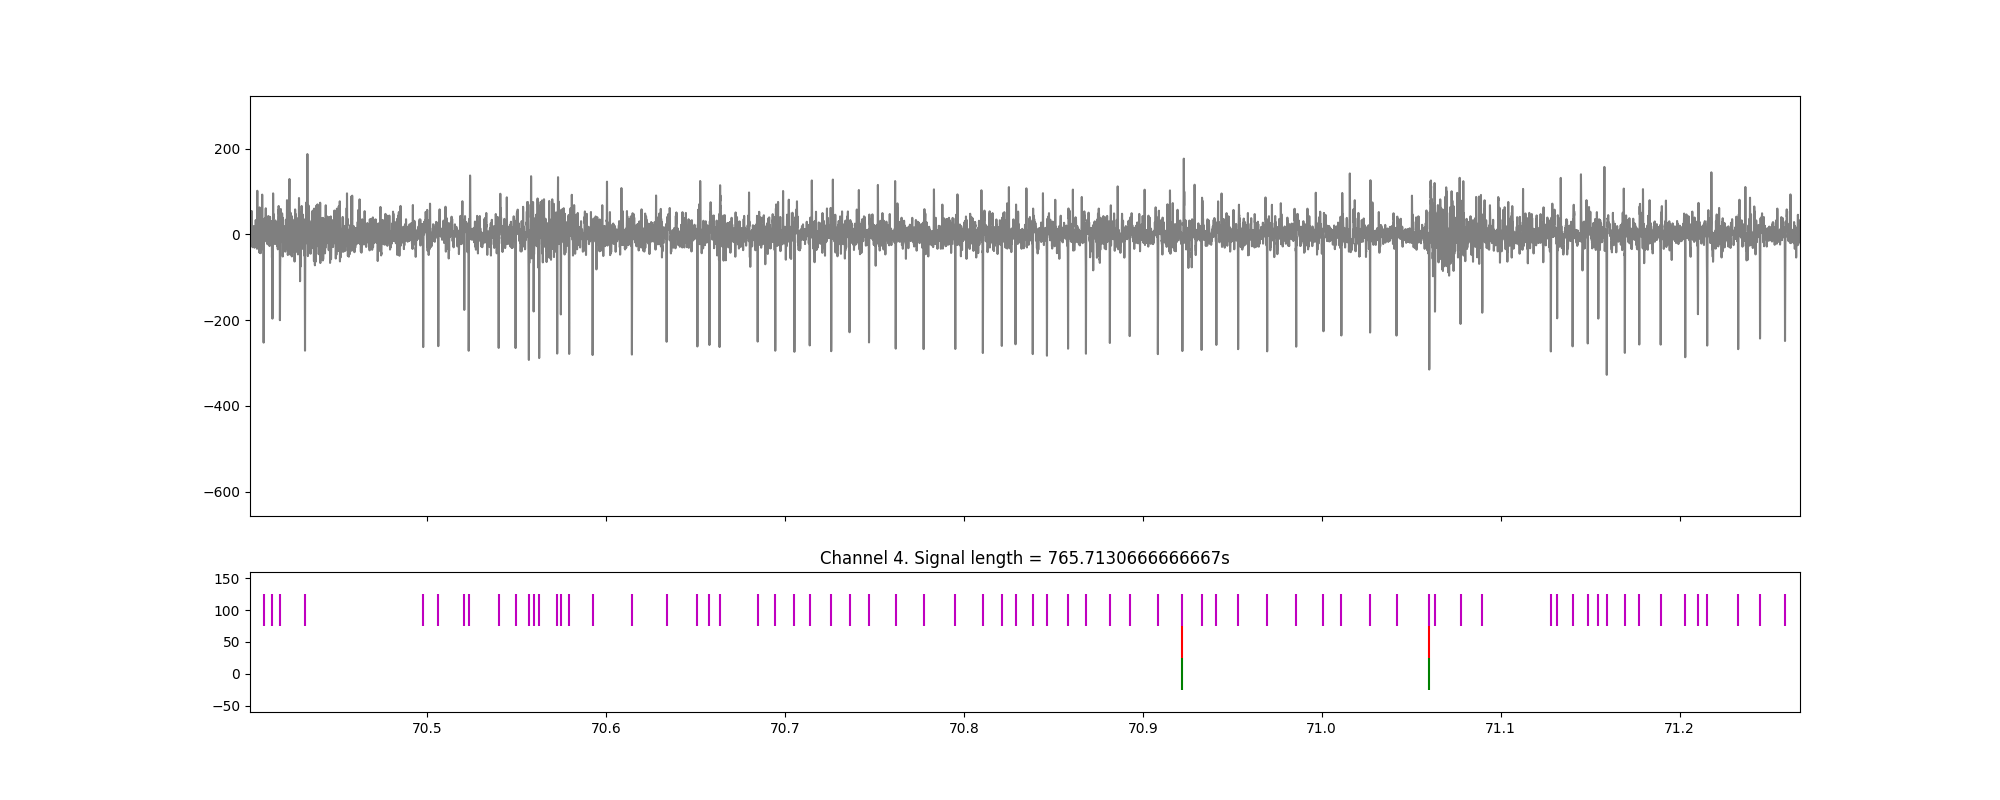

Text(0.5, 1.0, 'Channel 4. Signal length = 765.7130666666667s')

In [18]:
# plot channel
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,8), sharex=True)

prange = [0,100] # Time range of the signal to look at (in seconds).
idx_voltage = [int(pr*Fs) for pr in prange]
ax0.plot(np.arange(prange[0],prange[1],1/Fs), css.voltage[idx_voltage[0]: idx_voltage[1]], alpha=0.5, color='k')
ax1.eventplot(cs_indices[np.where(np.logical_and(cs_indices < idx_voltage[1] , cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=50, color='r')
plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.shape[1]/Fs))

   ## Saving the detected CS and SS

In [35]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

writing ../data/OpenEphys_data/2019-04-03/2019-04-03_14-13-13/channel_3.CS.csv ... 
writing ../data/OpenEphys_data/2019-04-03/2019-04-03_14-13-13/channel_3.SS.csv ... 
